In [8]:
from pathlib import Path
from xpinn import XPINN
from pinn import PINN
import optax
from type_util import Array
from jax import jacobian, jit, vmap
import jax.numpy as np

# Initializing the XPINN
We begin by reading the points from the relevant file, and setting the activation function for the networks.

In [9]:
from utils import data_path

file = data_path / "train_advection.json"
file_test = data_path / "test_advection.json"
save_path = data_path.parent / "figures/advection"
save_path.mkdir(exist_ok=True, parents=True)
xpinn = XPINN(file, np.tanh)

We plot the points of the domain decomposition. This is beneficial in keeping track of which sub-PINN has which index.

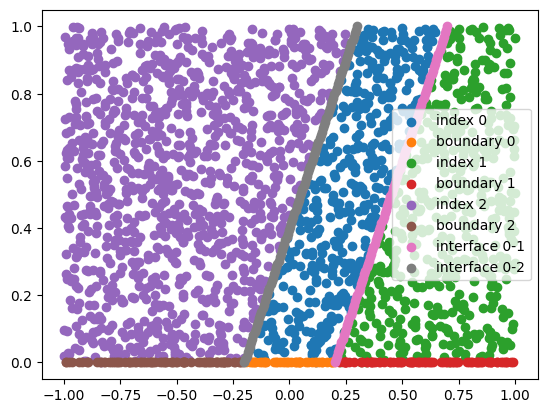

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

for i, pinn in enumerate(xpinn.PINNs):
    checkout = pinn.interior
    plt.scatter(checkout[:, 0], checkout[:, 1], label=f"index {i}")
    plt.scatter(pinn.boundary[:, 0], pinn.boundary[:, 1], label=f"boundary {i}")

for interface in xpinn.Interfaces:
    a, b = interface.indices
    p = interface.points
    plt.scatter(p[:, 0], p[:, 1], label=f"interface {a}-{b}")

plt.legend()

# Problem specifications
We consider the 1-D advection equation, defined by
$$
\begin{equation}
    u_t + 0.5 u_x = 0, \quad x \in [-1, 1], t \in [0, 1]
\end{equation}
$$
with the initial conditions
$$
\begin{cases}
    u(x, 0) = 1 & x \in [-0.2, 0.2] \\
    u(x, 0) = 0 & \text{otherwise}
\end{cases}
$$
In the middle PINN, we can set the boundary loss simply as
$$
\begin{equation}
    \lVert \mathcal{N}_{\theta}(x_b, 0) - 1 \rVert_2,
\end{equation}
$$
while for the left and right PINNs we set
$$
\begin{equation}
    \lVert \mathcal{N}_{\theta}(x_b, 0) - 0\rVert_2,
\end{equation}
$$

## Setting the loss function

We create a base function for intializing the boundary loss functions, which is relatively simple in this case.

In [11]:
from typing import Callable
from type_util import Params

LFunc = Callable[[Params, dict[str, Array]], Array]


def create_boundary_loss(index: int, target: float | Array) -> LFunc:
    def boundary_loss(params: Params, args: dict[str, Array]) -> Array:
        points = args["boundary"]
        eval = xpinn.PINNs[index].v_model(params, points)
        return np.mean((eval - target) ** 2)

    return boundary_loss

We precompute the relevant derivatives of the interior loss function, in order to speed things up down the line.

In [12]:
# fmt: off
def create_interior_loss(index: int, alpha: float = 0.5) -> LFunc:
    model = xpinn.PINNs[index].model
    jacob = lambda params: jacobian(lambda x: model(params, x))
    N_dx = lambda params, x: jacob(params)(x)[0, 0]
    N_dt = lambda params, x: jacob(params)(x)[0, 1]
    residual = lambda params, x: (N_dt(params, x) + alpha * N_dx(params, x))
    # v_residual = vmap(residual, (None, 0))
    v_residual = jit(vmap(residual, (None, 0)))
    xpinn.PINNs[index].v_residual = v_residual

    def interior_loss(params: Params, args: dict[str, Array]) -> Array:
        points = args["interior"]
        return np.mean(v_residual(params, points) ** 2)

    return interior_loss
# fmt: on

We now override the boundary and interior loss function of the networks to the updated versions.

In [13]:
p0, p1, p2 = xpinn.PINNs

p0.boundary_loss = create_boundary_loss(0, 1.0)
p1.boundary_loss = create_boundary_loss(1, 0.0)
p2.boundary_loss = create_boundary_loss(2, 0.0)

p0.interior_loss = create_interior_loss(0)
p1.interior_loss = create_interior_loss(1)
p2.interior_loss = create_interior_loss(2)

In the interface losses, we rely on outside communication for updating the values.

In [14]:
def create_inter(i: int, j: int) -> LFunc:

    a, b = sorted([i, j])
    pi = xpinn.PINNs[i]

    def interface_loss(params: Params, args: dict[str, Array]) -> Array:
        inter_points = args[f"interface {a}{b}"]

        res_j = args[f"interface res {j}"]
        res_ij = np.mean((pi.v_residual(params, inter_points) - res_j) ** 2)
        # res_ij = 0

        val_j = args[f"interface val {j}"]
        avg_ij = np.mean(((pi.v_model(params, inter_points) - val_j) / 2) ** 2)
        # avg_ij = 0

        return res_ij + avg_ij

    # return lambda params, args: 0
    return interface_loss

Again, setting the updated functions.

In [15]:
p0.interface_loss = lambda params, args: create_inter(0, 1)(
    params, args
) + create_inter(0, 2)(params, args)
# p0.interface_loss = lambda params, args: 0
p1.interface_loss = lambda params, args: create_inter(1, 0)(params, args)
p2.interface_loss = lambda params, args: create_inter(2, 0)(params, args)

We can now set the total loss for each network

## Setting up the arcitechture of the network

In [16]:
shapes = [[2] + [20] * 6 + [1]] * 3
optimizer = optax.adam(learning_rate=1e-4)
xpinn.initialize_params(shapes, optimizer)

In [17]:
n_iter = 10000
losses = xpinn.run_iters(n_iter)

0.00% iter = 0 of 10000: Total loss = 3.1572834849357605
10.00% iter = 1000 of 10000: Total loss = 0.23297259211540222
20.00% iter = 2000 of 10000: Total loss = 0.07180903479456902
30.00% iter = 3000 of 10000: Total loss = 0.021463416516780853
40.00% iter = 4000 of 10000: Total loss = 0.010526580736041069
50.00% iter = 5000 of 10000: Total loss = 0.006393676216248423
60.00% iter = 6000 of 10000: Total loss = 0.004431562629179098
70.00% iter = 7000 of 10000: Total loss = 0.003017110357177444
80.00% iter = 8000 of 10000: Total loss = 0.0017530736477056053
90.00% iter = 9000 of 10000: Total loss = 0.0011240646708756685
100.00% iter = 10000 of 10000: Total loss = 0.00040431607703794725


It's limited how low the loss can be for this problem, while still being physically correct. This stems from the inherent discontinuity from the interfaces, specifically from the averaging of the predicted values. If we in the interface loss function set `avg_ij` to be constant zero, the networks give a lot better results. Here, we want one side of the interface to predict constant $0$, while we want the other side to predict $1$. It can be discussed what the right approach in handling this problem is, given both the simplicity of the problem, and the fact that we have the analytical solution readily available.

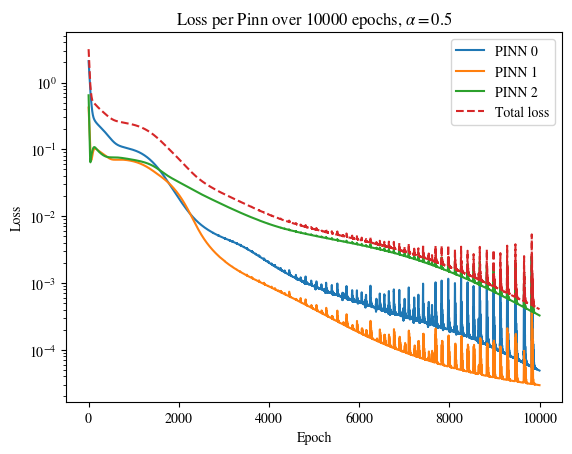

In [18]:
from plotutils import plot_losses

title = rf"Loss per Pinn over {n_iter} epochs, $\alpha={0.5}$"
plot_losses(losses, n_iter=n_iter, savepath=save_path, title=title)

Without looking further into the behaviour at present time, it seems like all of the networks predict values close to zero in the begninning. This leads to it seemingly being correct for PINNs 1 and 2, and seriously wrong for PINN 0. This is expected, as in the begninning epochs the models have not been trained yet. As PINN 0 improves, it starts predicting non-zero values, lowering it's own loss. However, we see that the loss for models 1 and 2 begins increasing, which I assume comes from an increased interface loss.

In [19]:
points, predictions = xpinn.predict(file_test)
total_pred = np.concatenate(predictions)
total_points = np.concatenate(points)
min_, max_ = total_pred.min(), total_pred.max()
# min_, max_ = 0, 1

In [20]:
total_pred.max()

Array(1.0073254, dtype=float32)

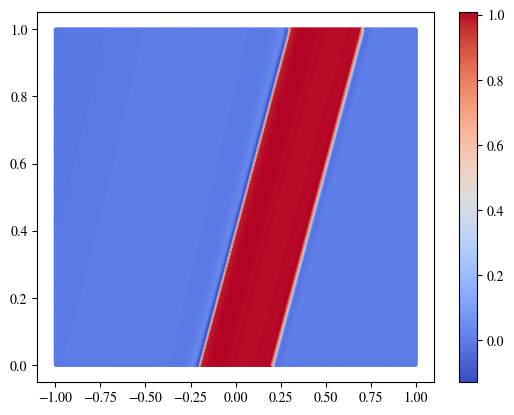

In [21]:
plt.scatter(
    total_points[:, 0],
    total_points[:, 1],
    c=total_pred,
    cmap="coolwarm",
    s=1,
)

plt.colorbar()

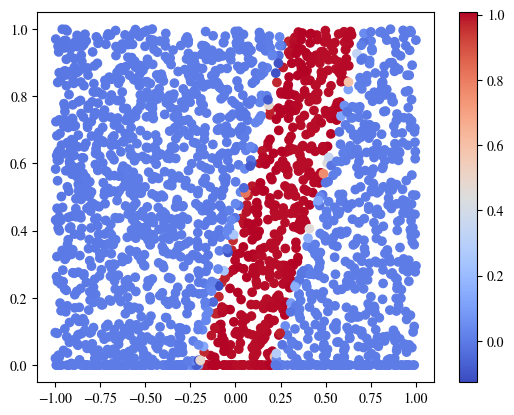

In [22]:
train_points, train_predictions = xpinn.predict()
total_train_pred = np.concatenate(train_predictions)
total_train_points = np.concatenate(train_points)
min_, max_ = total_train_pred.min(), total_train_pred.max()
# min_, max_ = 0, 1

plt.scatter(
    total_train_points[:, 0],
    total_train_points[:, 1],
    c=total_train_pred,
    cmap="coolwarm",
)


plt.colorbar()

In [23]:
from plotutils import compare_analytical_advection

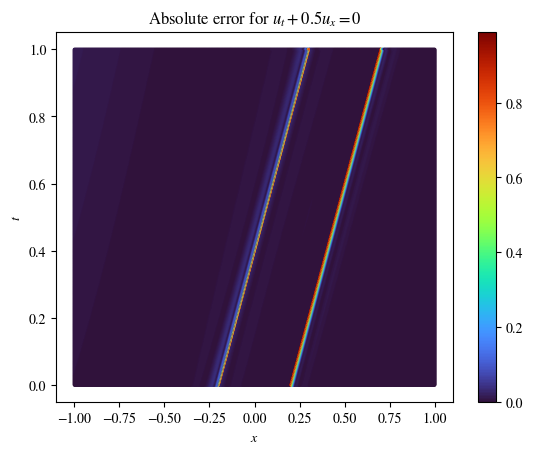

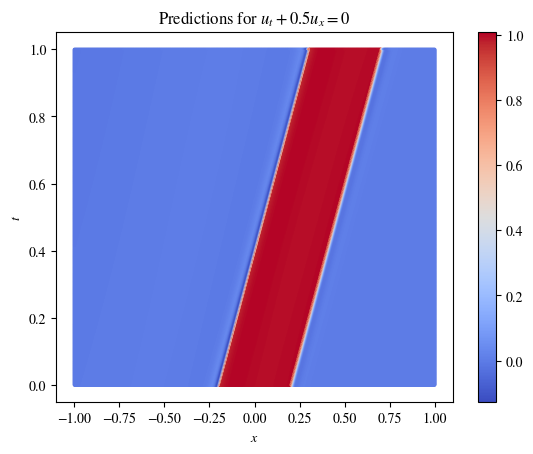

In [24]:
compare_analytical_advection(xpinn, file_test, savepath=save_path)

Here we see that the model predicts the interior of each subdomain correctly. When falsely predicting it biases towards one at the intersections. It also has a few false zeros but only on the intersection with the rightmost domain.

## Stress testing the model
To ensure the network is acctually learning the boundaries from its cost function and not the subdomains themselves, we create a new model with a different velocity such that
\begin{equation}
    u_t + (-1) u_x = 0, \quad x \in [-1, 1], t \in [0, 1]
\end{equation}
But with the same subdomains as defined in advection_points.ipynb

In [25]:
xpinn_n = XPINN(file, np.tanh)

p0_n, p1_n, p2_n = xpinn_n.PINNs

p0_n.boundary_loss = create_boundary_loss(0, 1.0)
p1_n.boundary_loss = create_boundary_loss(1, 0.0)
p2_n.boundary_loss = create_boundary_loss(2, 0.0)

alpha = -1

p0_n.interior_loss = create_interior_loss(0, alpha)
p1_n.interior_loss = create_interior_loss(1, alpha)
p2_n.interior_loss = create_interior_loss(2, alpha)

p0_n.interface_loss = lambda params, args: create_inter(0, 1)(
    params, args
) + create_inter(0, 2)(params, args)
p1_n.interface_loss = lambda params, args: create_inter(1, 0)(params, args)
p2_n.interface_loss = lambda params, args: create_inter(2, 0)(params, args)

shapes = [[2] + [20] * 6 + [1]] * 3
optimizer = optax.adam(learning_rate=1e-4)
xpinn_n.initialize_params(shapes, optimizer)

n_iter = 10000
losses = xpinn_n.run_iters(n_iter)

0.00% iter = 0 of 10000: Total loss = 3.1351728439331055
10.00% iter = 1000 of 10000: Total loss = 0.1796947605907917
20.00% iter = 2000 of 10000: Total loss = 0.11068621650338173
30.00% iter = 3000 of 10000: Total loss = 0.06784532032907009
40.00% iter = 4000 of 10000: Total loss = 0.03369359951466322
50.00% iter = 5000 of 10000: Total loss = 0.02694449946284294
60.00% iter = 6000 of 10000: Total loss = 0.020297705195844173
70.00% iter = 7000 of 10000: Total loss = 0.013071153778582811
80.00% iter = 8000 of 10000: Total loss = 0.00928689818829298
90.00% iter = 9000 of 10000: Total loss = 0.007485229172743857
100.00% iter = 10000 of 10000: Total loss = 0.006120055797509849


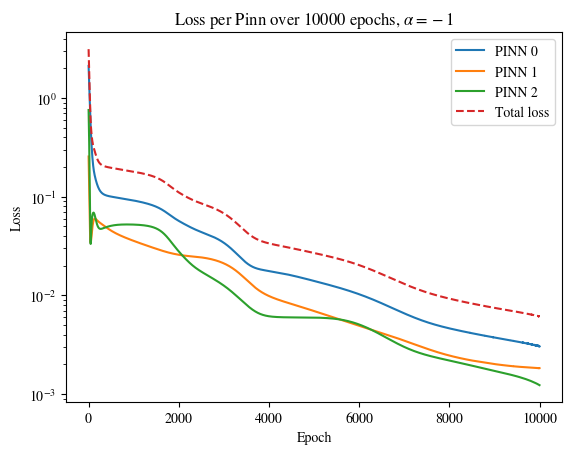

In [26]:
title = rf"Loss per Pinn over {n_iter} epochs, $\alpha={alpha}$"
plot_losses(losses, n_iter=n_iter, savepath=save_path, title=title)

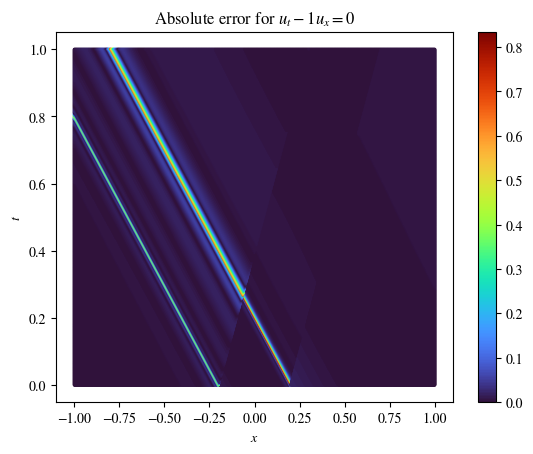

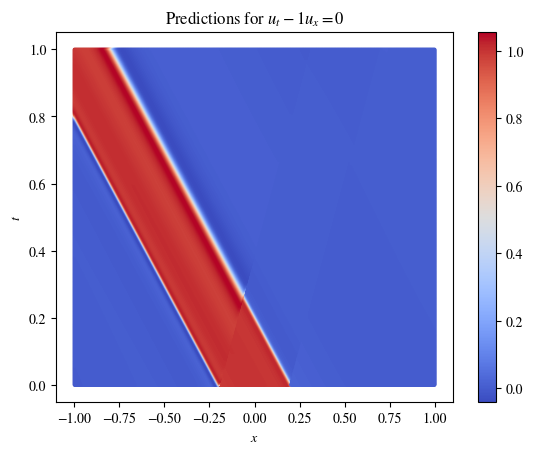

In [47]:
compare_analytical_advection(
    xpinn_n, file_test, savepath=save_path, alpha=alpha)

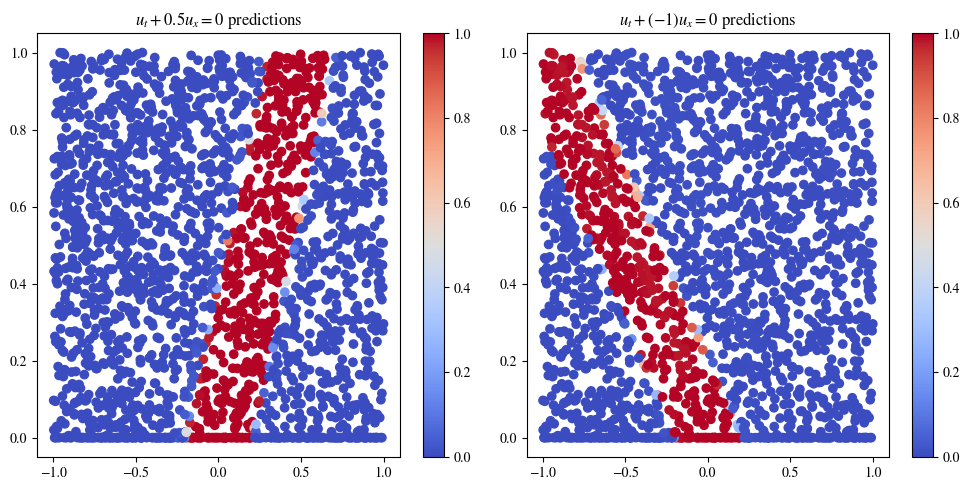

In [28]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot

points, predictions = xpinn.predict()
total_pred = np.concatenate(predictions)
min_, max_ = 0, 1
for point, pred in zip(points, predictions):
    plt.scatter(point[:, 0], point[:, 1], c=pred, cmap="coolwarm", vmin=min_, vmax=max_)

plt.colorbar()
plt.title("$u_t + 0.5 u_x = 0$ predictions")

# start second plot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot

points, predictions = xpinn_n.predict()
total_pred = np.concatenate(predictions)

for point, pred in zip(points, predictions):
    plt.scatter(point[:, 0], point[:, 1], c=pred, cmap="coolwarm", vmin=min_, vmax=max_)

plt.colorbar()
plt.title("$u_t + (-1) u_x = 0$ predictions")

plt.tight_layout()
plt.show()

# PINN vs XPINN

Some things work after here

In [69]:
file_single_train = data_path / "train_single_advection.json"

single_pinn = XPINN(file_single_train, np.tanh)

# Sanity check

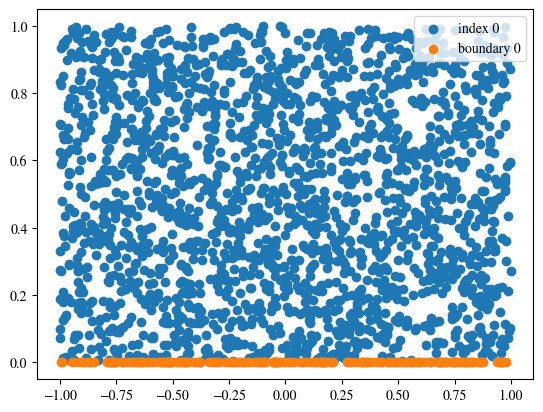

In [70]:
%matplotlib inline
import matplotlib.pyplot as plt

for i, pinn in enumerate(single_pinn.PINNs):
    checkout = pinn.interior
    plt.scatter(checkout[:, 0], checkout[:, 1], label=f"index {i}")
    plt.scatter(pinn.boundary[:, 0], pinn.boundary[:, 1], label=f"boundary {i}")

plt.legend()

### Setting the single PINNs special boundary

In [71]:
import jax.numpy as np
import numpy as onp
def eval(x):
    a = 0
    if -0.2<=x[0]<=0.2:
        a=1
    return a

def f():
    points=single_pinn.PINNs[0].boundary
    f=onp.zeros_like(points)
    for i,point in enumerate(points):
        f[i] = eval(point)
    return np.array(f)

boundary_values = f()

# Initializing single PINN

In [78]:
p = single_pinn.PINNs[0]
print(single_pinn.PINNs)

p.interior_loss = create_interior_loss(0, alpha=0.5)
p.boundary_loss = create_boundary_loss(0, boundary_values)

p.create_loss()


<PjitFunction of <function PINN.create_loss.<locals>.loss at 0x2dd624c20>>

In [79]:
shapes = [[2] + [20] * 6 + [1]]
optimizer = optax.adam(learning_rate=1e-4)
single_pinn.initialize_params(shapes, optimizer)

# Training single PINN

In [80]:
# use same n_iter as for the XPINN
simple_losses = single_pinn.run_iters(n_iter)

0.00% iter = 0 of 10000: Total loss = 0.6159044504165649
10.00% iter = 1000 of 10000: Total loss = 0.06555376946926117
20.00% iter = 2000 of 10000: Total loss = 0.020641988143324852
30.00% iter = 3000 of 10000: Total loss = 0.01697707176208496
40.00% iter = 4000 of 10000: Total loss = 0.010827894322574139
50.00% iter = 5000 of 10000: Total loss = 0.006060012150555849
60.00% iter = 6000 of 10000: Total loss = 0.002838902873918414
70.00% iter = 7000 of 10000: Total loss = 0.0011584802996367216
80.00% iter = 8000 of 10000: Total loss = 0.0004962359671480954
90.00% iter = 9000 of 10000: Total loss = 0.00020144294830970466
100.00% iter = 10000 of 10000: Total loss = 6.483244214905426e-05


# Performance single PINN

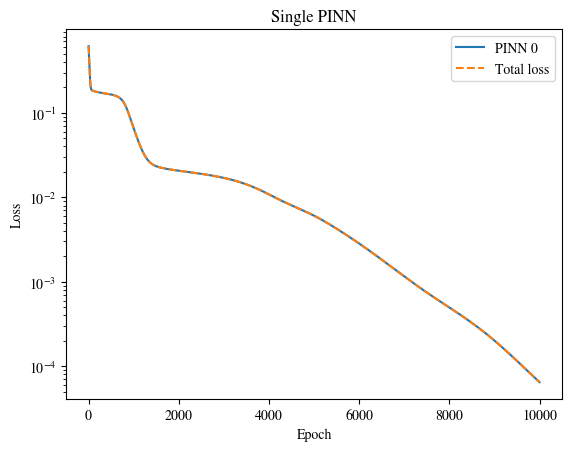

In [81]:
plot_losses(simple_losses, n_iter=n_iter, savepath=save_path, title="Single PINN")

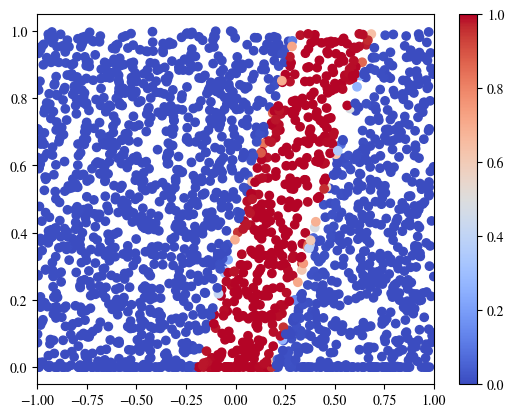

In [82]:
points, predictions = single_pinn.predict(file_single_train)
total_pred = np.concatenate(predictions)

for point, pred in zip(points, predictions):
    plt.scatter(point[:, 0], point[:, 1], c=pred, cmap="coolwarm")
    plt.clim(0, 1)

plt.xlim(-1, 1)
plt.colorbar()

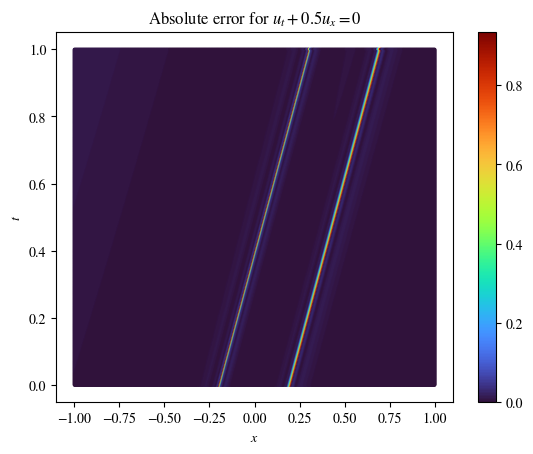

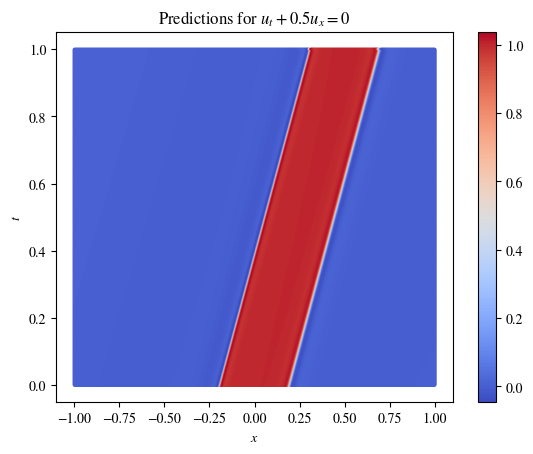

In [83]:
file_test_single = data_path / "test_single_advection.json"
compare_analytical_advection(single_pinn, file_test_single, savepath=save_path)